### BPIC2011
Bucket: Prefix

Encoding: Aggregation

Classifier: XGBoost

The notebook has all the code for running the benchmark and deriving explanations

In [1]:
import EncoderFactory
from DatasetManager import DatasetManager
import BucketFactory

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import lime
import lime.lime_tabular
from lime import submodular_pick;
import warnings
warnings.filterwarnings('ignore')

### Utility function to generate feature importance of XGBoost

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def imp_df(column_names, importances):
        df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
        return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title, num_feat):
        imp_df.columns = ['feature', 'feature_importance']
        b= sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df.head(num_feat), orient = 'h', palette="Blues_r") 
        b.set_title(title, fontsize = 14) 
    
        for item in b.get_yticklabels():
            item.set_fontsize(13)

In [3]:
def generate_global_explanations(train_X,train_Y, cls, feature_combiner):
    
    print("The number of testing instances is ",len(train_Y))
    print("The total number of columns is",train_X.shape[1]);
    print("The total accuracy is ",cls.score(train_X,train_Y));
       
    sns.set(style="darkgrid")
    sns.set(rc={'figure.figsize':(10,10), "font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    sns.set
    feat_names = feature_combiner.get_feature_names()
    base_imp = imp_df(feat_names, cls.feature_importances_)
    base_imp.head(15)
    #var_imp_plot(base_imp, 'Feature importance using Random forest', 15)
    return base_imp
    

### Generate Local Explanations using LIME

In [4]:
from lime import submodular_pick
def generate_local_explanations(explainer,test_xi, cls,test_y, submod=False, test_all_data=None):
    
    print("Actual value ", test_y)
    num_features=6;# maximum is 6 ,if it is larger than 6, the features displayed are different.
    exp = explainer.explain_instance(test_xi, 
                                 cls.predict_proba, num_features=num_features, labels=[0,1])
    
    #exp.show_in_notebook(show_table=True, show_all=False);
    probability_result=cls.predict_proba([test_xi])[0];
    print(probability_result);
    print ('Explanation for class %s' % class_names[1])
    print ('\n'.join(map(str, exp.as_list(label=1))))
    return exp
    #%matplotlib inline
    #fig = exp.as_pyplot_figure()
        
    if submod==True:
        sp_obj=submodular_pick.SubmodularPick(explainer, test_all_data, cls.predict_proba, 
                                      sample_size=20, num_features=num_features,num_exps_desired=4)
        [exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];

### Benchmark code
1. Contain additional updates to include generation of importances
2. Stores classification for prefix lengths of 5,10, 15, 20 and 25

In [5]:

dataset_ref = "bpic2011"
params_dir = "params"
results_dir = "results"
bucket_method = "prefix"
cls_encoding = "agg"
cls_method = "xgboost"
gap = 1
n_iter = 1

if bucket_method == "state":
    bucket_encoding = "last"
else:
    bucket_encoding = "agg"

method_name = "%s_%s"%(bucket_method, cls_encoding)

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2011": ["bpic2011_f%s"%formula for formula in range(4,5)],
    "bpic2012" : ["bpic2012_accepted"]
    #"insurance": ["insurance_activity", "insurance_followup"],
    #"sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

encoding_dict = {
    "laststate": ["static", "last"],
    "agg": ["static", "agg"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]
methods = encoding_dict[cls_encoding]
    
train_ratio = 0.8
random_state = 22

# create results directory
if not os.path.exists(os.path.join(params_dir)):
    os.makedirs(os.path.join(params_dir))
    
print(datasets)

['bpic2011_f4']


In [6]:
for dataset_name in datasets:
    
    # load optimal params
    optimal_params_filename = os.path.join(params_dir, "optimal_params_%s_%s_%s.pickle" % (cls_method, dataset_name, method_name))
    print(optimal_params_filename)
    if not os.path.isfile(optimal_params_filename) or os.path.getsize(optimal_params_filename) <= 0:
        continue
        
    with open(optimal_params_filename, "rb") as fin:
        args = pickle.load(fin)
        
    print(args)
    bucket_list=[5,10,20,25] #:)
    # read the data
    dataset_manager = DatasetManager(dataset_name)
    data = dataset_manager.read_dataset()
    cls_encoder_args = {'case_id_col': dataset_manager.case_id_col, 
                        'static_cat_cols': dataset_manager.static_cat_cols,
                        'static_num_cols': dataset_manager.static_num_cols, 
                        'dynamic_cat_cols': dataset_manager.dynamic_cat_cols,
                        'dynamic_num_cols': dataset_manager.dynamic_num_cols, 
                        'fillna': True}

    # determine min and max (truncated) prefix lengths
    min_prefix_length = 1
    if "traffic_fines" in dataset_name:
        max_prefix_length = 10
    elif "bpic2017" in dataset_name:
        max_prefix_length = min(20, dataset_manager.get_pos_case_length_quantile(data, 0.90))
    else:
        max_prefix_length = min(40, dataset_manager.get_pos_case_length_quantile(data, 0.90))

    # split into training and test
    train, test = dataset_manager.split_data_strict(data, train_ratio, split="temporal")
    
    if gap > 1:
        outfile = os.path.join(results_dir, "performance_results_%s_%s_%s_gap%s.csv" % (cls_method, dataset_name, method_name, gap))
    else:
        outfile = os.path.join(results_dir, "performance_results_%s_%s_%s.csv" % (cls_method, dataset_name, method_name))
        
    start_test_prefix_generation = time.time()
    dt_test_prefixes = dataset_manager.generate_prefix_data(test, min_prefix_length, max_prefix_length)
    test_prefix_generation_time = time.time() - start_test_prefix_generation
            
    offline_total_times = []
    online_event_times = []
    train_prefix_generation_times = []
    explained=False
    impotance=None
    exp_ddict=dict()
    exp_rdict=dict()
    model_dict=dict()
    importance_dict=dict()
    for ii in range(n_iter):
        # create prefix logs
        start_train_prefix_generation = time.time()
        dt_train_prefixes = dataset_manager.generate_prefix_data(train, min_prefix_length, max_prefix_length, gap)
        train_prefix_generation_time = time.time() - start_train_prefix_generation
        train_prefix_generation_times.append(train_prefix_generation_time)
            
        # Bucketing prefixes based on control flow
        bucketer_args = {'encoding_method':bucket_encoding, 
                         'case_id_col':dataset_manager.case_id_col, 
                         'cat_cols':[dataset_manager.activity_col], 
                         'num_cols':[], 
                         'random_state':random_state}
        if bucket_method == "cluster":
            bucketer_args["n_clusters"] = int(args["n_clusters"])
        bucketer = BucketFactory.get_bucketer(bucket_method, **bucketer_args)

        start_offline_time_bucket = time.time()
        bucket_assignments_train = bucketer.fit_predict(dt_train_prefixes)
        offline_time_bucket = time.time() - start_offline_time_bucket

        bucket_assignments_test = bucketer.predict(dt_test_prefixes)

        preds_all = []
        test_y_all = []
        nr_events_all = []
        offline_time_fit = 0
        current_online_event_times = []
        
        for bucket in set(bucket_assignments_test):
            print("Bucket" , bucket )
            #args has only one value - some error and so just using it
            #if bucket_method == "prefix":
            #    current_args = args[bucket]
            #else:
            current_args = args
            relevant_train_cases_bucket = dataset_manager.get_indexes(dt_train_prefixes)[bucket_assignments_train == bucket]
            relevant_test_cases_bucket = dataset_manager.get_indexes(dt_test_prefixes)[bucket_assignments_test == bucket]
            dt_test_bucket = dataset_manager.get_relevant_data_by_indexes(dt_test_prefixes, relevant_test_cases_bucket)
            
            nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_bucket)))
            print('number events', len(nr_events_all))
            
            if len(relevant_train_cases_bucket) == 0:
                preds = [dataset_manager.get_class_ratio(train)] * len(relevant_test_cases_bucket)
                current_online_event_times.extend([0] * len(preds))
            else:
                dt_train_bucket = dataset_manager.get_relevant_data_by_indexes(dt_train_prefixes, relevant_train_cases_bucket) # one row per event
                train_y = dataset_manager.get_label_numeric(dt_train_bucket)

                if len(set(train_y)) < 2:
                    preds = [train_y[0]] * len(relevant_test_cases_bucket)
                    current_online_event_times.extend([0] * len(preds))
                    test_y_all.extend(dataset_manager.get_label_numeric(dt_test_bucket))
                else:
                    start_offline_time_fit = time.time()
                    feature_combiner = FeatureUnion([(method, EncoderFactory.get_encoder(method, **cls_encoder_args)) for method in methods])

                    if cls_method == "rf":
                        cls = RandomForestClassifier(n_estimators=500,
                                                     max_features=current_args['max_features'],
                                                     random_state=random_state)

                    elif cls_method == "xgboost":
                        cls = xgb.XGBClassifier(objective='binary:logistic',
                                                n_estimators=500,
                                                learning_rate= current_args['learning_rate'],
                                                subsample=current_args['subsample'],
                                                max_depth=int(current_args['max_depth']),
                                                colsample_bytree=current_args['colsample_bytree'],
                                                min_child_weight=int(current_args['min_child_weight']),
                                                seed=random_state)

                    elif cls_method == "logit":
                        cls = LogisticRegression(C=2**current_args['C'],
                                                 random_state=random_state)

                    elif cls_method == "svm":
                        cls = SVC(C=2**current_args['C'],
                                  gamma=2**current_args['gamma'],
                                  random_state=random_state)

                    if cls_method == "svm" or cls_method == "logit":
                        pipeline = Pipeline([('encoder', feature_combiner), ('scaler', StandardScaler()), ('cls', cls)])
                    else:
                        pipeline = Pipeline([('encoder', feature_combiner), ('cls', cls)])

                    pipeline.fit(dt_train_bucket, train_y)
                    #get the explainations for the model now
        
                    print("Training model iteration ", ii )
                    
                    #get the training data as a matrix
                    trainingdata=feature_combiner.fit_transform(dt_train_bucket);
                    if bucket in bucket_list:
                        importance = generate_global_explanations(trainingdata,train_y, cls, feature_combiner)
                        #create an explainer now that can be passed later
                        class_names=['regular','deviant']# regular is 0, deviant is 1, 0 is left, 1 is right
                        explainer = lime.lime_tabular.LimeTabularExplainer(trainingdata,
                                                    feature_names = feature_combiner.get_feature_names(),
                                                   class_names=class_names, discretize_continuous=True)
                        importance_dict[bucket]=importance
                        #exp_dict[bucket]=explainer
                        model_dict[bucket]=cls
                    
                    
                    offline_time_fit += time.time() - start_offline_time_fit

                    # predict separately for each prefix case
                    preds = []
                    
                    test_all_grouped = dt_test_bucket.groupby(dataset_manager.case_id_col)
                    print(dt_test_bucket.shape)
                    count_d=0
                    count_r=0
                    for _, group in test_all_grouped:
                        
                        test_y_group = dataset_manager.get_label_numeric(group)
                        test_y_all.extend(test_y_group)
                            
                        start = time.time()
                        _ = bucketer.predict(group)
                        
                        if cls_method == "svm":
                            pred = pipeline.decision_function(group)
                        else:
                            preds_pos_label_idx = np.where(cls.classes_ == 1)[0][0]
                            pred = pipeline.predict_proba(group)[:,preds_pos_label_idx]
                            #print(test_y_group)
                            if bucket in bucket_list and (count_d<3 or count_r<3):
                                test_x_group= feature_combiner.fit_transform(group)
                                print(test_x_group.shape,test_y_group[0], _)
                                test_x=np.transpose(test_x_group[0])
                                print('Generating local Explanations for', dataset_manager.get_case_ids(group))
                                exp=generate_local_explanations(explainer, test_x, cls, test_y_group )
                                if(test_y_group[0]==1):
                                    count_d=count_d+1
                                    exp_ddict[bucket+count_d]=exp
                                else:
                                    count_r=count_r+1
                                    exp_rdict[bucket+count_r]=exp
                                
                        pipeline_pred_time = time.time() - start
                        current_online_event_times.append(pipeline_pred_time / len(group))
                        preds.extend(pred)
                        

            preds_all.extend(preds)

      
   
        dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": nr_events_all})
        for nr_events, group in dt_results.groupby("nr_events"):
            if len(set(group.actual)) < 2:
                print(dataset_name, method_name, cls_method, nr_events, "auc", np.nan)
            else:
                #if nr_events in [5, 10, 25] and explained=False:
                #    generate_local_explanations(explainer,group[j],cls )
                #    explained=True
                print(dataset_name, method_name, cls_method, nr_events, "auc", roc_auc_score(group.actual, group.predicted))
        print(dataset_name, method_name, cls_method, -1, -1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted))
        
            


params\optimal_params_xgboost_bpic2011_f4_prefix_agg.pickle
{'colsample_bytree': 0.7459515180000027, 'learning_rate': 0.6373187476692391, 'max_depth': 20, 'min_child_weight': 3, 'subsample': 0.8208008973160263}
prefix
Bucket 1
number events 228
Training model iteration  0
(228, 26)
Bucket 2
number events 455
Training model iteration  0
(454, 26)
Bucket 3
number events 673
Training model iteration  0
(654, 26)
Bucket 4
number events 886
Training model iteration  0
(852, 26)
Bucket 5
number events 1093
Training model iteration  0
The number of testing instances is  722
The total number of columns is 963
The total accuracy is  1.0
(1035, 26)
(1, 963) 1 [5]
Generating local Explanations for 0    1001_5
Name: Case ID, dtype: object
Actual value  [1]
[0.00274438 0.9972556 ]
Explanation for class deviant
('static__Treatment code_TC803 > 0.00', 0.47095353023403225)
('static__Treatment code_TC813 <= 0.00', -0.2054741864541717)
('static__Treatment code_TC603 <= 0.00', -0.179535588380143)
('stati

Bucket 11
number events 2282
Training model iteration  0
(2145, 26)
Bucket 12
number events 2477
Training model iteration  0
(2340, 26)
Bucket 13
number events 2671
Training model iteration  0
(2522, 26)
Bucket 14
number events 2863
Training model iteration  0
(2688, 26)
Bucket 15
number events 3055
Training model iteration  0
(2880, 26)
Bucket 16
number events 3247
Training model iteration  0
(3072, 26)
Bucket 17
number events 3439
Training model iteration  0
(3264, 26)
Bucket 18
number events 3630
Training model iteration  0
(3438, 26)
Bucket 19
number events 3820
Training model iteration  0
(3610, 26)
Bucket 20
number events 4010
Training model iteration  0
The number of testing instances is  515
The total number of columns is 923
The total accuracy is  1.0
(3800, 26)
(1, 923) 1 [20]
Generating local Explanations for 0    1001_20
Name: Case ID, dtype: object
Actual value  [1]
[0.03340816 0.96659184]
Explanation for class deviant
('static__Treatment code_TC803 > 0.00', 0.400896035218

[0.0055452 0.9944548]
Explanation for class deviant
('static__Treatment code_TC803 <= 0.00', -0.4278017409965333)
('289.76 < agg__mean_open_cases <= 442.00', -0.14102868801214716)
('agg__max_event_nr > 28.00', 0.13134848320225104)
('agg__Activity code_AC10107 <= 0.00', -0.12299494543879189)
('agg__Specialism code.1_SC86 <= 19.00', -0.11420911148785018)
('static__Specialism code_SC61 <= 0.00', 0.10596463641172923)
(1, 911) 0 [25]
Generating local Explanations for 0    1005_25
Name: Case ID, dtype: object
Actual value  [0]
[0.97223645 0.02776352]
Explanation for class deviant
('static__Treatment code_TC803 <= 0.00', -0.4168477001949943)
('289.76 < agg__mean_open_cases <= 442.00', -0.15387301458430522)
('agg__Activity code_AC10107 <= 0.00', -0.13311549023801686)
('0.00 < static__Specialism code_SC61 <= 1.00', -0.1159602357414665)
('agg__Producer code_SGNA <= 0.00', 0.11227855792155234)
('6.00 < agg__mean_month <= 9.00', 0.10615223780556417)
(1, 911) 1 [25]
Generating local Explanations fo

### Plot Local Explanations

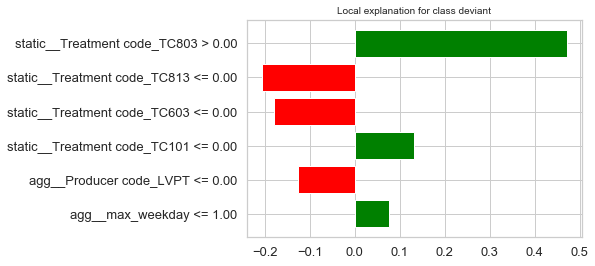

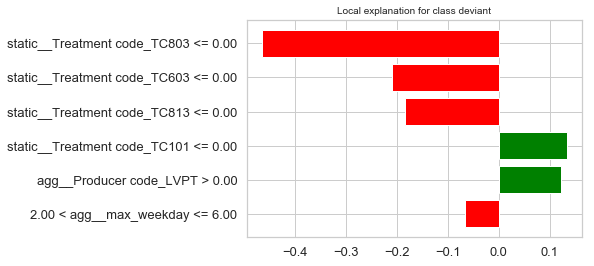

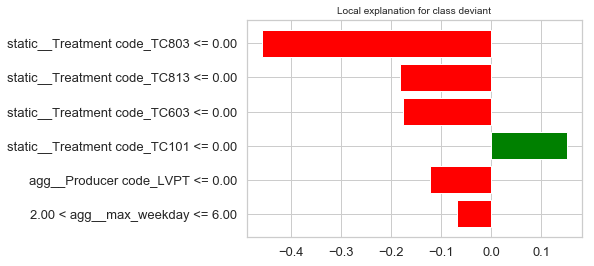

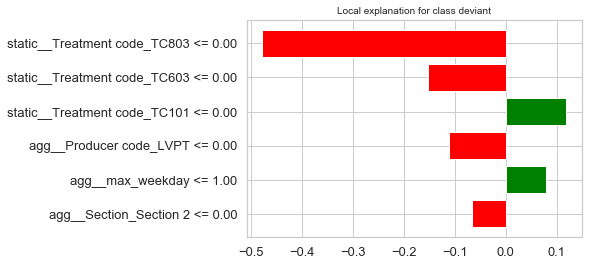

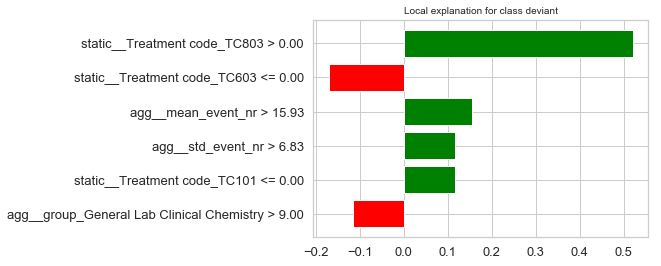

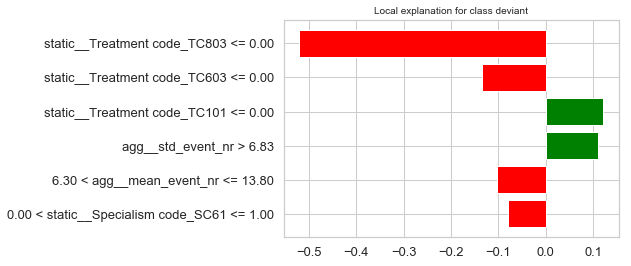

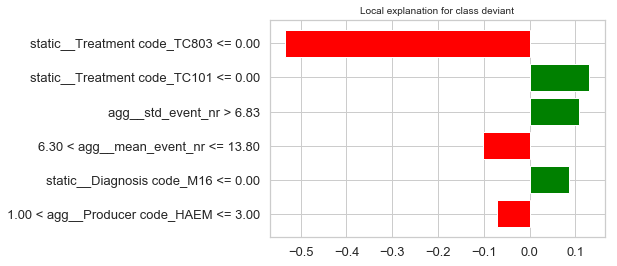

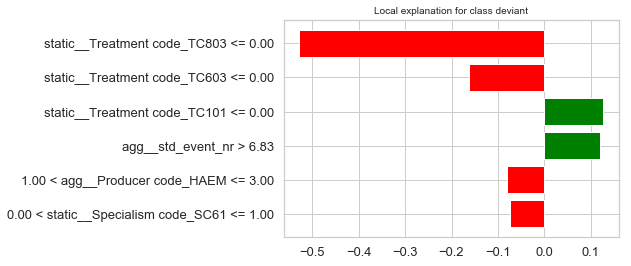

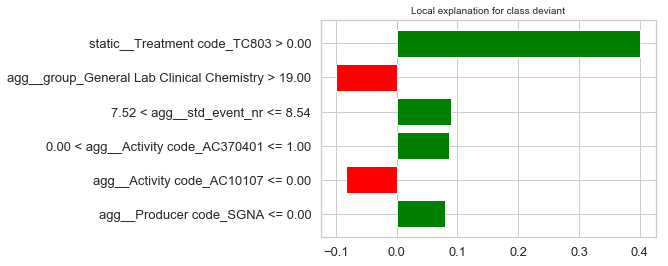

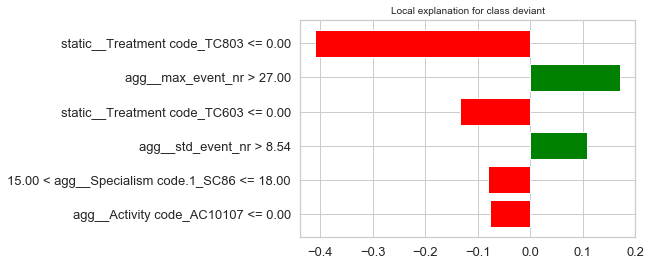

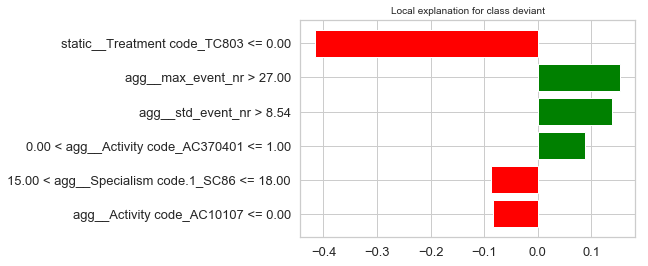

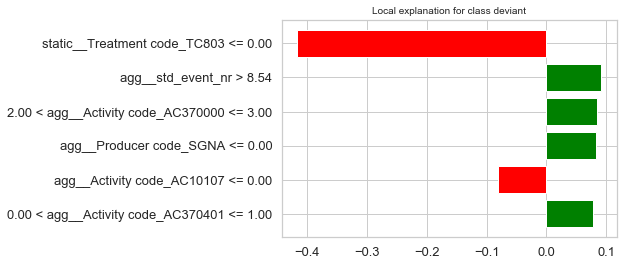

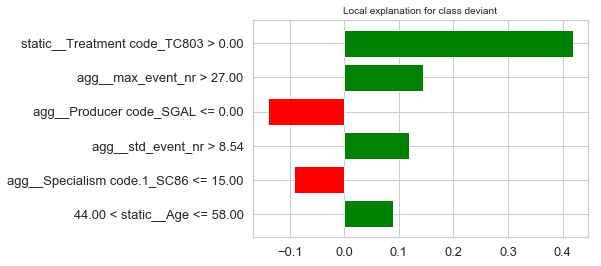

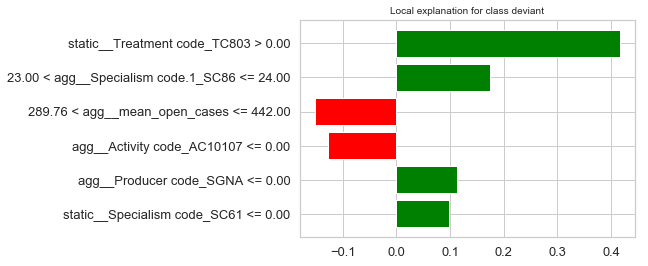

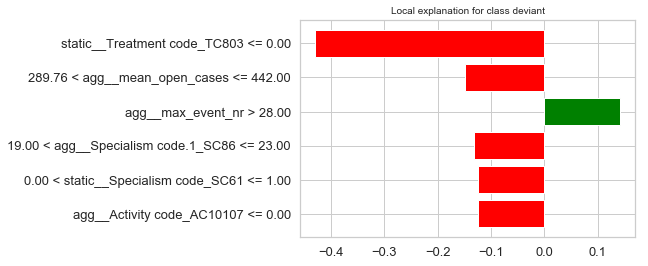

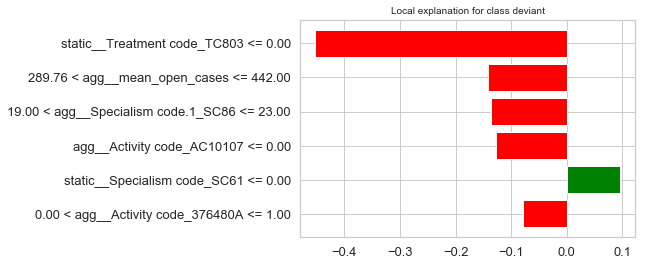

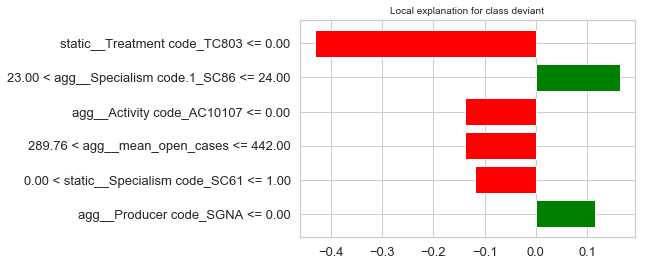

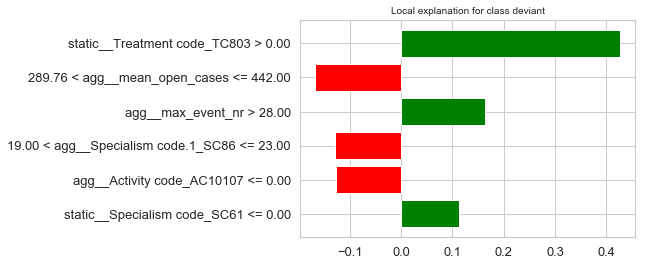

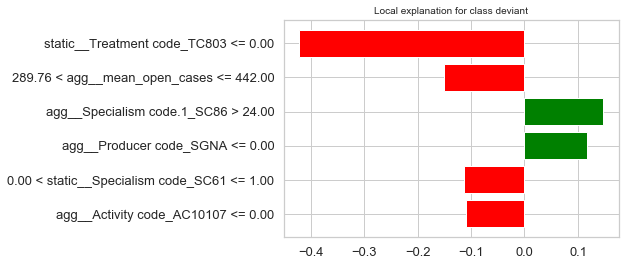

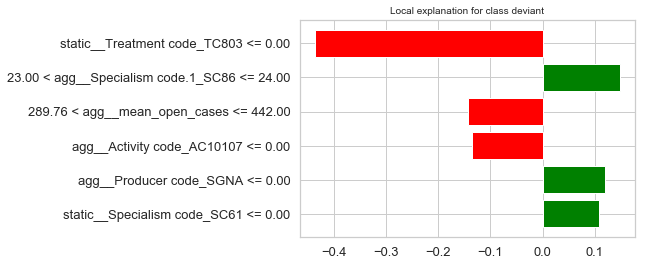

In [7]:
rc={'axes.labelsize': 12, 'xtick.labelsize': 13, 'ytick.labelsize': 13 , 'axes.titlesize': 10}
sns.set(rc)
sns.set_style("whitegrid")
%matplotlib inline
for pre, exp in exp_ddict.items():
    #print('Explanations for prefix length ', pre)
    fig = exp.as_pyplot_figure()

### Feature importance of XGBoost

printing global feature importance of the XGBoost classifier 25                                feature  feature_importance
0         static__Treatment code_TC813            0.216536
1         static__Treatment code_TC603            0.130983
2          agg__Activity code_AC350503            0.064189
3          agg__Activity code_AC355201            0.048598
4         static__Treatment code_TC103            0.035886
5         static__Treatment code_TC113            0.033596
6         static__Treatment code_TC803            0.032766
7          agg__Activity code_AC370000            0.028829
8  static__Diagnosis_maligniteit vulva            0.028756
9         static__Treatment code_TC101            0.026357


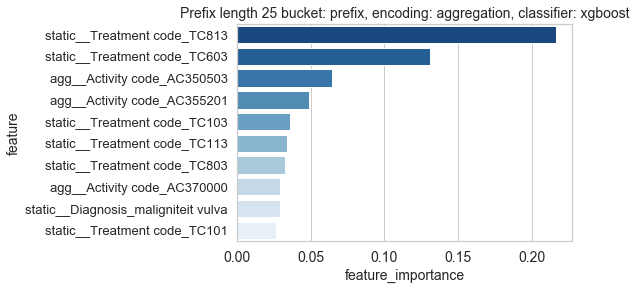

In [10]:
rc={'axes.labelsize': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14 ,'axes.titlesize': 15}
sns.set(rc)
sns.set_style("whitegrid")
for pre, importance in importance_dict.items():
    if(pre==25):
        print('printing global feature importance of the XGBoost classifier', pre, importance.head(10)) 
        title = 'Prefix length {} bucket: prefix, encoding: aggregation, classifier: xgboost'.format(pre)
        var_imp_plot(importance, title, 10)
        